In [22]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from collections import Counter
import sklearn.metrics as metrics

## 데이터 로드

In [18]:
data = pd.read_csv("hate_speech_large.csv")
data.columns = ["comments", "label"]
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,1
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,1
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,0
3,@착한아이임당 A4 용지 덮고?,0
4,"진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다. 네티즌,전문가 하나같이...",1


In [19]:
print("댓글 개수 :",len(data)) # 댓글 개수 출력

댓글 개수 : 190000


## 데이터 정제

In [20]:
data['label'] = np.where(data['label'] == 0, 1, 0)

### 댓글의 중복 여부 확인

In [21]:
data['comments'].nunique(), data['label'].nunique()

(187142, 2)

In [22]:
data.drop_duplicates(subset=['comments'], inplace=True) # 중복 코멘트 제거
data.shape

(187143, 2)

In [23]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 187143


#### 레이블 값의 분포

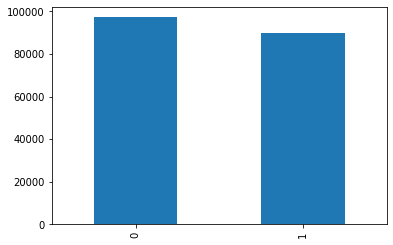

In [24]:
data['label'].value_counts().plot(kind = 'bar')

In [25]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  97223
1      1  89920


### Null 값 제거

In [26]:
print(data.isnull().values.any())

True


In [27]:
print(data.isnull().sum())

comments    1
label       0
dtype: int64


In [28]:
data.loc[data.comments.isnull()]

,comments,label
7807,NaN,0


In [29]:
data = data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [30]:
print(len(data))

187142


### 한글, 공백 제외 전처리

In [31]:
data['comments'] = data['comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data.head()

,comments,label
0,정말 재밌다 연기도 좋고 디카프리오 짱,0
1,심쿵심쿵 미치네요이수혁땜에 잠 못자겠어요ㅠ자꾸 아른거림ㅠ,0
2,하지만 이니후빨러들은 이런거 관심 하나도 없음,1
3,착한아이임당 용지 덮고,1
4,진짜 평점 믿으면 안된 다는 걸 현실로 보여주는 영화입니다 네티즌전문가 하나같이 영...,0


In [32]:
data['comments'] = data['comments'].str.strip()
data['comments'].replace('', np.nan, inplace=True)
print(data.isnull().sum())

comments    1021
label          0
dtype: int64


In [33]:
data = data.dropna(how = 'any')
print(len(data))

186121


### 데이터 분리

In [34]:
train_data = data[:150000]
test_data = data[150000:]

train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [35]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [37]:
mecab = Mecab()

## EDA

### 워드클라우드
* 긍정/부정 댓글에서 빈도수가 가장 높은 명사들을 시각화

명사 추출 함수

In [40]:
def get_nouns(data, label):
    subset = data[data['label'] == label]
    text = subset['comments']
    
    morphs = []
    for sentence in text:
        morphs.append(mecab.pos(sentence))

    nouns = []
    for morph in morphs:
        for word, tag in morph:
            if tag in ['Noun']:
                nouns.append(word)
    
    count = Counter(nouns)
    words = dict(count.most_common())
    
    return words

positive = get_nouns(train_data, 0)
negative = get_nouns(train_data, 1)

워드 클라우드 생성 함수

In [43]:
def generate_word_cloud(data, img, title, cmap):
    clean_mask = np.array(Image.open(str(img) + ".png"))
    clean_mask = clean_mask[:,:,1]

    wc = WordCloud(font_path ='NanumGothic.ttf', 
                   background_color ="black",
                   max_words = 2000,
                   mask = clean_mask,
                   stopwords = stopwords)

    wc.generate(" ".join(data))
    plt.figure(figsize = (20, 10))
    plt.axis("off")
    plt.title(title, fontsize = 30)
    plt.imshow(wc.recolor(colormap = cmap, random_state = 17), alpha = 0.98)
    plt.savefig(title + ".png")

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
generate_word_cloud(positive, "safe-zone", "긍정 댓글 명사 빈도", "viridis")
generate_word_cloud(negative, "anger", "부정 댓글 명사 빈도", "hot")

FileNotFoundError: ignored

## 토큰화

In [52]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [47]:

X_train = []
for sentence in train_data['comments']:
    temp_X = []
    temp_X = mecab.morphs(sentence,) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [48]:
print(X_train[0])

['정말', '재밌', '다', '연기', '좋', '고', '디카프리오', '짱']


In [51]:
X_test = []
for sentence in test_data['comments']:
    temp_X = []
    temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [52]:
print(X_test[0])

['문채원', '짱', '너무나', '사랑', '스럽', '고', '귀엽', '고', '문채원', '매력', '푹', '빠져', '보', '세요']


In [53]:
with open("data/mecab_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
    
with open("data/mecab_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

# 여기서 시작 ---------------------------------------------------------

In [2]:
import re
import pickle
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from konlpy.tag import Okt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### okt

In [105]:
with open("data/khaiii_train.pkl", "rb") as f:
    X_train = pickle.load(f)
    
with open("data/khaiii_test.pkl", "rb") as f:
    X_test = pickle.load(f)

In [106]:
print(len(X_test),len(X_train))

36121 150000


In [107]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

## 정수 인코딩

In [108]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [109]:
print(len(tokenizer.word_index))

129184


In [110]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 129184
등장 빈도가 2번 이하인 희귀 단어의 수: 100312
단어 집합에서 희귀 단어의 비율: 77.65048303195442
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.675132833710812


In [111]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 28874


In [112]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [113]:
print(X_train[:3])

[[50, 65, 5, 95, 24, 4, 3286, 267], [22494, 1, 86, 14395, 1022, 1507, 91, 54, 48, 1, 18823, 3, 21, 1100, 69], [2655, 51, 380, 1017, 10, 92, 21, 681, 167, 30, 37]]


In [114]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [115]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

6

In [116]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

149994
149994


## 패딩

리뷰의 최대 길이 : 431
리뷰의 평균 길이 : 16.29295171806872


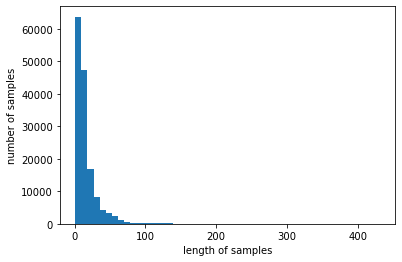

In [117]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [118]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [119]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 95.58449004626853


In [120]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [121]:
len(X_train)

149994

In [122]:
len(X_test)

36121

## RNN으로 악성 댓글 분류

In [123]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [130]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(SimpleRNN(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('khaiii_RNN_single.h5', monitor='val_acc', 
                     mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], 
                    batch_size=60, validation_split=0.2)

Epoch 1/15
2000/2000 [==============================] - ETA: 0s - loss: 0.2534 - acc: 0.8907
Epoch 00001: val_acc improved from -inf to 0.92550, saving model to khaiii_RNN_single.h5
2000/2000 [==============================] - 59s 30ms/step - loss: 0.2534 - acc: 0.8907 - val_loss: 0.1830 - val_acc: 0.9255
Epoch 2/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1932 - acc: 0.9234
Epoch 00002: val_acc improved from 0.92550 to 0.92850, saving model to khaiii_RNN_single.h5
2000/2000 [==============================] - 58s 29ms/step - loss: 0.1932 - acc: 0.9234 - val_loss: 0.1893 - val_acc: 0.9285
Epoch 3/15
2000/2000 [==============================] - ETA: 0s - loss: 0.1721 - acc: 0.9315
Epoch 00003: val_acc improved from 0.92850 to 0.93080, saving model to khaiii_RNN_single.h5
2000/2000 [==============================] - 59s 29ms/step - loss: 0.1721 - acc: 0.9315 - val_loss: 0.1785 - val_acc: 0.9308
Epoch 4/15
2000/2000 [==============================] - ETA: 0s - loss: 0

In [131]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         2887400   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 128)               29312     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 2,916,841
Trainable params: 2,916,841
Non-trainable params: 0
_________________________________________________________________


In [125]:
loaded_model = load_model('khaiii_RNN_single.h5')
print("\n테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1129/1129 [==============================] - 4s 3ms/step - loss: 0.1666 - acc: 0.9358

테스트 정확도: 0.9358


In [126]:
from sklearn.metrics import confusion_matrix
pred = loaded_model.predict(X_test)
results = confusion_matrix(y_true=y_test, y_pred=pred.round())

print(results)

[[17095  1455]
 [  864 16707]]


In [127]:
y_test_decode = []
for i in range(len(y_test)):
    if y_test[i] >= 0.5:
        y_test_decode.append(1)
    else:
        y_test_decode.append(0)
len(y_test_decode)
pred = model.predict(X_test)
pred_decode = []
for i in range(len(pred)):
    if pred[i] >= 0.5:
        pred_decode.append(1)
    else:
        pred_decode.append(0)
pred

array([[0.00327623],
       [0.98846   ],
       [0.1353536 ],
       ...,
       [0.81414086],
       [0.04449466],
       [0.97150326]], dtype=float32)

In [128]:
print('f1 : ',metrics.f1_score(y_test_decode, pred_decode, average='macro'))
print('recall : ', metrics.recall_score(y_test_decode,pred_decode,average='macro'))
print('precision : ',metrics.precision_score(y_test_decode,pred_decode,average='macro'))
print('accuracy', metrics.accuracy_score(y_test_decode, pred_decode,))

f1 :  0.8883749779953503
recall :  0.8889914618258061
precision :  0.88893708448192
accuracy 0.8883751834113119


In [129]:
okt = Okt()

In [50]:
def sentiment_predict(new_sentence):
    sent = new_sentence
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{}: {:.2f}% --.\n".format(sent, score * 100))
    else:
        print("{}: {:.2f}% ++.\n".format(sent, (1 - score) * 100))

In [55]:
for sentence in test_data['comments'][:100]:
    sentiment_predict(sentence)

문채원 짱 너무나 사랑스럽고 귀엽고 문채원의 매력에 푹 빠져보세요: 99.78% ++.

익명 육사 조지는거: 99.71% --.

재미만있구만: 97.46% ++.

내가 지인들에게 가장 추천하고픈 영화: 99.84% ++.

가슴에 사무치게 따뜻한 영화ㅋ: 99.64% ++.

이건뭐 우리 강지환씨가 다 살려주네 그려차도남 현기준의 무한매력에 빠져있느라 다른캐릭터는눈에 들어오지도 않았음ㅋㅋ어쨌든 만화같은 이야기 넘 재밌게 봄: 99.69% ++.

무능보다 거짓말이래 ㅋㅋㅋ 탈당했다가 복당 짓은 거짓말이냐 무능이냐 저런 의원들  상황에따라 적이 바뀌고 말이 바뀌는 사람들  저러는 이유는 다른거 없다 지가 정치 계속하고 싶고 의원 계속하고 싶기 때문이지 속은 주판말 퉁기면서 겉으론 입바른 소리: 99.32% --.

강남권서울멋쟁이 ㄱㅅ: 98.63% --.

의사가 일부러 그런것도 아니고 저정도 고수들만 의사하라고 하면 당장 국민이 더 불편함 어쩔 수 없는거임: 99.75% --.

진중권 ㅇㅂ: 99.80% --.

서울 안살면 대부분  전화번호 안받음: 99.64% --.

임기말쯤 터질듯결국 바둑이랑기: 81.00% --.

김수현의 불륜에는 뭔가 철학이 있더라: 98.68% ++.

사랑에눈멀어눈에뵈는게없는게아니라 사랑을 기성세대의 틀로 억압한 결과지 무식아: 94.24% ++.

익명 중일러 헬조셴도 만만치않은듯: 99.57% --.

머가리폭도컷 아오 씨발ㅋㅋ 존나웃기노: 99.43% --.

오프리 윈프리 맞나: 93.04% --.

사랑을알아가는데필요한시간을잘말해주는영화: 99.85% ++.

이게 점짜리지: 96.98% ++.

나도 그러던데지들이 걸어놓고 갑자기 귀하는 해당지역 조사대상이 아니래 ㅋ: 99.59% --.

사무엘잭슨은 좀빼라 못봐주겠다: 80.89% ++.

제발 세컨더리 보이콧 해주세요: 89.79% --.

샤이니오빠들 사랑해요 지금은 빛나는 우리 샤이니 시대 진기종현기범민호태민 오빠 사랑해요: 99.79% ++.

영